# maxvogt-analysis: Mörschwil

The code in this notebook is based on [Martin Fleischmann's](https://martinfleischmann.net/) 2021 workshop [*Capturing the Structure of Cities with Data Science (SDSC)*](https://github.com/martinfleis/sdsc21-workshop), licensed under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). © 2021 Martin Fleischmann.

The geodata in this notebook is retrieved from OpenStreetMap. © OpenStreetMap Contributors.

<hr>

This notebook contains geodata and analyses for the following items of the [Max Vogt collection](https://mtwente.github.io/maxvogt/) by Moritz Twente and Luisa Omonsky:
- [MOER011](https://mtwente.github.io/maxvogt/items/moer011.html)

<hr>

Open in an interactive in-browser environment: 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mtwente/maxvogt-analysis/main?labpath=analysis%2Fmörschwil.ipynb)

In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [4]:
place = 'Mörschwil, Schweiz'
local_crs = 'EPSG:2056'

In [5]:
geopandas.tools.geocode(place).explore()

## Input data

Download data from OpenStreetMap.

### Buildings

In [6]:
buildings = osmnx.features.features_from_place(place, tags={'building':True})

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/sit

In [7]:
buildings

geometry  \
element_type osmid                                                           
way          99510314    POLYGON ((9.41433 47.47483, 9.41436 47.47483, ...   
             99846306    POLYGON ((9.41466 47.47416, 9.41457 47.47430, ...   
             108110376   POLYGON ((9.42304 47.45321, 9.42308 47.45326, ...   
             126072364   POLYGON ((9.44603 47.47093, 9.44639 47.47103, ...   
             155672628   POLYGON ((9.45029 47.47184, 9.44989 47.47197, ...   
...                                                                    ...   
             1295633225  POLYGON ((9.41185 47.45395, 9.41204 47.45394, ...   
             1295633227  POLYGON ((9.41303 47.45399, 9.41337 47.45399, ...   
             1295633228  POLYGON ((9.41355 47.45398, 9.41378 47.45398, ...   
             1295633229  POLYGON ((9.41290 47.45378, 9.41304 47.45378, ...   
             1295633231  POLYGON ((9.41244 47.45450, 9.41268 47.45452, ...   

                                                                     nodes  \
element_type osmid                                                           
way          99510314    [2496387427, 1151019792, 12051872190, 11510197...   
             99846306    [1154289203, 1154289216, 1154289267, 115428919...   
             108110376   [1240898034, 1240898024, 1240898022, 124089800...   
             126072364   [1398583757, 1398583746, 1398583749, 139858376...   
             155672628   [1680554380, 6835051423, 6835051422, 168055438...   
...                                                                    ...   
             1295633225  [12005914428, 12005914429, 12005914430, 120059...   
             1295633227  [12005914444, 12005914445, 12005914454, 120059...   
             1295633228  [12005914448, 12005914449, 12005914450, 120059...   
             1295633229  [12005914456, 12005914457, 12005914458, 120059...   
             1295633231  [12005914464, 12005914465, 12005914466, 120059...   

                         addr:city addr:housenumber addr:postcode  \
element_type osmid                                                  
way          99510314    Mörschwil               55          9402   
             99846306          NaN              NaN           NaN   
             108110376   Mörschwil              NaN          9402   
             126072364   Mörschwil               95          9402   
             155672628   Mörschwil              102          9402   
...                            ...              ...           ...   
             1295633225  Mörschwil               21          9402   
             1295633227  Mörschwil               13          9402   
             1295633228        NaN              NaN           NaN   
             1295633229        NaN              NaN           NaN   
             1295633231  Mörschwil               18          9402   

                                addr:street architect architect:wikidata  \
element_type osmid                                                         
way          99510314        Bahnhofstrasse  Max Vogt           Q1913571   
             99846306                   NaN       NaN                NaN   
             108110376   Rorschacherstrasse       NaN                NaN   
             126072364   Rorschacherstrasse       NaN                NaN   
             155672628   Rorschacherstrasse       NaN                NaN   
...                                     ...       ...                ...   
             1295633225                 NaN       NaN                NaN   
             1295633227                 NaN       NaN                NaN   
             1295633228                 NaN       NaN                NaN   
             1295633229                 NaN       NaN                NaN   
             1295633231                 NaN       NaN                NaN   

                              building    wikidata  ... smoking wheelchair  \
element_type osmid                                  ...                

In [8]:
buildings.geom_type.value_counts()

Polygon    1054
Name: count, dtype: int64

In [9]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [10]:
buildings = buildings[["geometry"]].to_crs(local_crs)

In [11]:
buildings["uID"] = range(len(buildings))

In [12]:
buildings

,geometry,uID
0,"POLYGON ((2748919.922 1260102.999, 2748921.622...",0
1,"POLYGON ((2748946.528 1260029.596, 2748938.912...",1
2,"POLYGON ((2749636.821 1257716.437, 2749639.691...",2
3,"POLYGON ((2751319.452 1259730.723, 2751346.581...",3
4,"POLYGON ((2751637.760 1259840.325, 2751607.687...",4
...,...,...
1049,"POLYGON ((2748791.064 1257778.179, 2748805.497...",1049
1050,"POLYGON ((2748879.812 1257784.617, 2748905.744...",1050
1051,"POLYGON ((2748919.351 1257784.812, 2748936.439...",1051
1052,"POLYGON ((2748870.882 1257760.558, 2748881.189...",1052


### Streets

In comparison to Martin Fleischmann's workshop, I here set `truncate_by_edge` to be `True`.
Depending on the OSM mapping quality of the place at hand, it might also be necessary to change the value of `network_type`. See [geopandas documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place) for options.

In [17]:
osm_graph = osmnx.graph_from_place(place, network_type='drive', truncate_by_edge=True)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [18]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [19]:
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [20]:
streets.explore()

In [21]:
streets

osmid  \
u          v          key                                                      
21402060   1194669390 0    [1236416641, 334585515, 225593169, 43222482, 4...   
21402061   2343567342 0    [1236416643, 26720234, 49612939, 1236416652, 3...   
           2343567288 0    [4969381, 4901291, 1236416653, 225593172, 2655...   
2343567342 32576091   0           [26720236, 552603221, 225593189, 26720239]   
2343567288 1194593502 0           [33680001, 334585562, 334585675, 26529095]   
...                                                                      ...   
6835187449 6835187451 0                                            729669582   
           6835187450 0                                            729669582   
6835187451 6835187449 0                                            729669582   
6835187450 6835187449 0                                            729669582   
6835268347 6835268340 0                                            729676897   

                           oneway   lanes  ref                    highway  \
u          v          key                                                   
21402060   1194669390 0      True  [2, 3]   A1                   motorway   
21402061   2343567342 0      True       2  A23  [motorway_link, motorway]   
           2343567288 0      True       2   A1                   motorway   
2343567342 32576091   0      True       3  A23                   motorway   
2343567288 1194593502 0      True  [2, 3]   A1                   motorway   
...                           ...     ...  ...                        ...   
6835187449 6835187451 0     False     NaN  NaN                residential   
           6835187450 0     False     NaN  NaN                residential   
6835187451 6835187449 0     False     NaN  NaN                residential   
6835187450 6835187449 0     False     NaN  NaN                residential   
6835268347 6835268340 0     False     NaN  NaN                residential   

                                     maxspeed reversed    length bridge  \
u          v          key                                                 
21402060   1194669390 0            [100, 120]    False  2733.217    yes   
21402061   2343567342 0    [100, 80, 120, 70]    False  1042.383    yes   
           2343567288 0                   120    False   692.122    yes   
2343567342 32576091   0             [70, 100]    False   503.215    yes   
2343567288 1194593502 0                   120    False   940.823    yes   
...                                       ...      ...       ...    ...   
6835187449 6835187451 0                   NaN    False    22.612    NaN   
           6835187450 0                   NaN     True    42.539    NaN   
6835187451 6835187449 0                   NaN     True    22.612    NaN   
6835187450 6835187449 0                   NaN    False    42.539    NaN   
6835268347 6835268340 0                   NaN     True    58.963    NaN   

                                                                    geometry  \
u          v          key                                                      
21402060   1194669390 0    LINESTRING (2750825.656 1259058.271, 2750760.6...   
21402061   2343567342 0    LINESTRING (2750909.401 1259186.389, 2750925.2...   
           2343567288 0    LINESTRING (2750909.401 1259186.389, 2750919.0...   
2343567342 32576091   0    LINESTRING (2751032.225 1259922.555, 2751021.6...   
2343567288 1194593502 0    LINESTRING (2751422.895 1259620.982, 2751461.3...   
...                                                                      ...   
6835187449 6835187451 0    LINESTRING (2749915.119 1259442.651, 2749937.6...   
           6835187450 0    LINESTRING (2749915.119 1259442.651, 2749872.7...   
6835187451 6835187449 0    LINESTRING (2749937.651 1259440.075, 2749915.1...   
6835187450 6835187449 0    LINESTRING (2749872.733 1259447.505, 2749915.1...   
6835268347 6835268340 0    LINESTRING (2750614.587 1258703.021, 2750588.2...   

           

In [22]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [23]:
streets

,geometry,nID
0,"LINESTRING (2750825.656 1259058.271, 2750760.6...",0
1,"LINESTRING (2750909.401 1259186.389, 2750925.2...",1
2,"LINESTRING (2750909.401 1259186.389, 2750919.0...",2
3,"LINESTRING (2751032.225 1259922.555, 2751021.6...",3
4,"LINESTRING (2751422.895 1259620.982, 2751461.3...",4
...,...,...
302,"LINESTRING (2750463.182 1258736.559, 2750486.9...",302
303,"LINESTRING (2750588.265 1258650.221, 2750614.5...",303
304,"LINESTRING (2751358.277 1261294.359, 2751357.5...",304
305,"LINESTRING (2751339.553 1260662.536, 2751355.3...",305


## Generated data

### Tessellation

We can generate a spatail unit using Voronoi tessellation with given building footprints.

In [24]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/1328706492.py:3: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/m

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [25]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [26]:
buildings

,geometry,uID,index_right,nID
0,"POLYGON ((2748919.922 1260102.999, 2748921.622...",0,267,267
1,"POLYGON ((2748946.528 1260029.596, 2748938.912...",1,267,267
2,"POLYGON ((2749636.821 1257716.437, 2749639.691...",2,85,85
3,"POLYGON ((2751319.452 1259730.723, 2751346.581...",3,306,306
4,"POLYGON ((2751637.760 1259840.325, 2751607.687...",4,306,306
...,...,...,...,...
1051,"POLYGON ((2748919.351 1257784.812, 2748936.439...",1051,72,72
1052,"POLYGON ((2748870.882 1257760.558, 2748881.189...",1052,76,76
1052,"POLYGON ((2748870.882 1257760.558, 2748881.189...",1052,72,72
1053,"POLYGON ((2748833.798 1257840.570, 2748852.028...",1053,76,76


In [27]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [28]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters.

### Dimensions

In [29]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [30]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/1902756608.py:1: FutureWarning: Class based API like `momepy.EquivalentRectangularIndex` is deprecated. Replace it with `momepy.equivalent_rectangular_index` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [31]:
buildings['elongation'] = momepy.Elongation(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/3723954296.py:1: FutureWarning: Class based API like `momepy.Elongation` is deprecated. Replace it with `momepy.elongation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['elongation'] = momepy.Elongation(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [32]:
tessellation['convexity'] = momepy.Convexity(tessellation).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/2335586521.py:1: FutureWarning: Class based API like `momepy.Convexity` is deprecated. Replace it with `momepy.convexity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['convexity'] = momepy.Convexity(tessellation).series


In [33]:
streets["linearity"] = momepy.Linearity(streets).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/3802614628.py:1: FutureWarning: Class based API like `momepy.Linearity` is deprecated. Replace it with `momepy.linearity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["linearity"] = momepy.Linearity(streets).series


/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


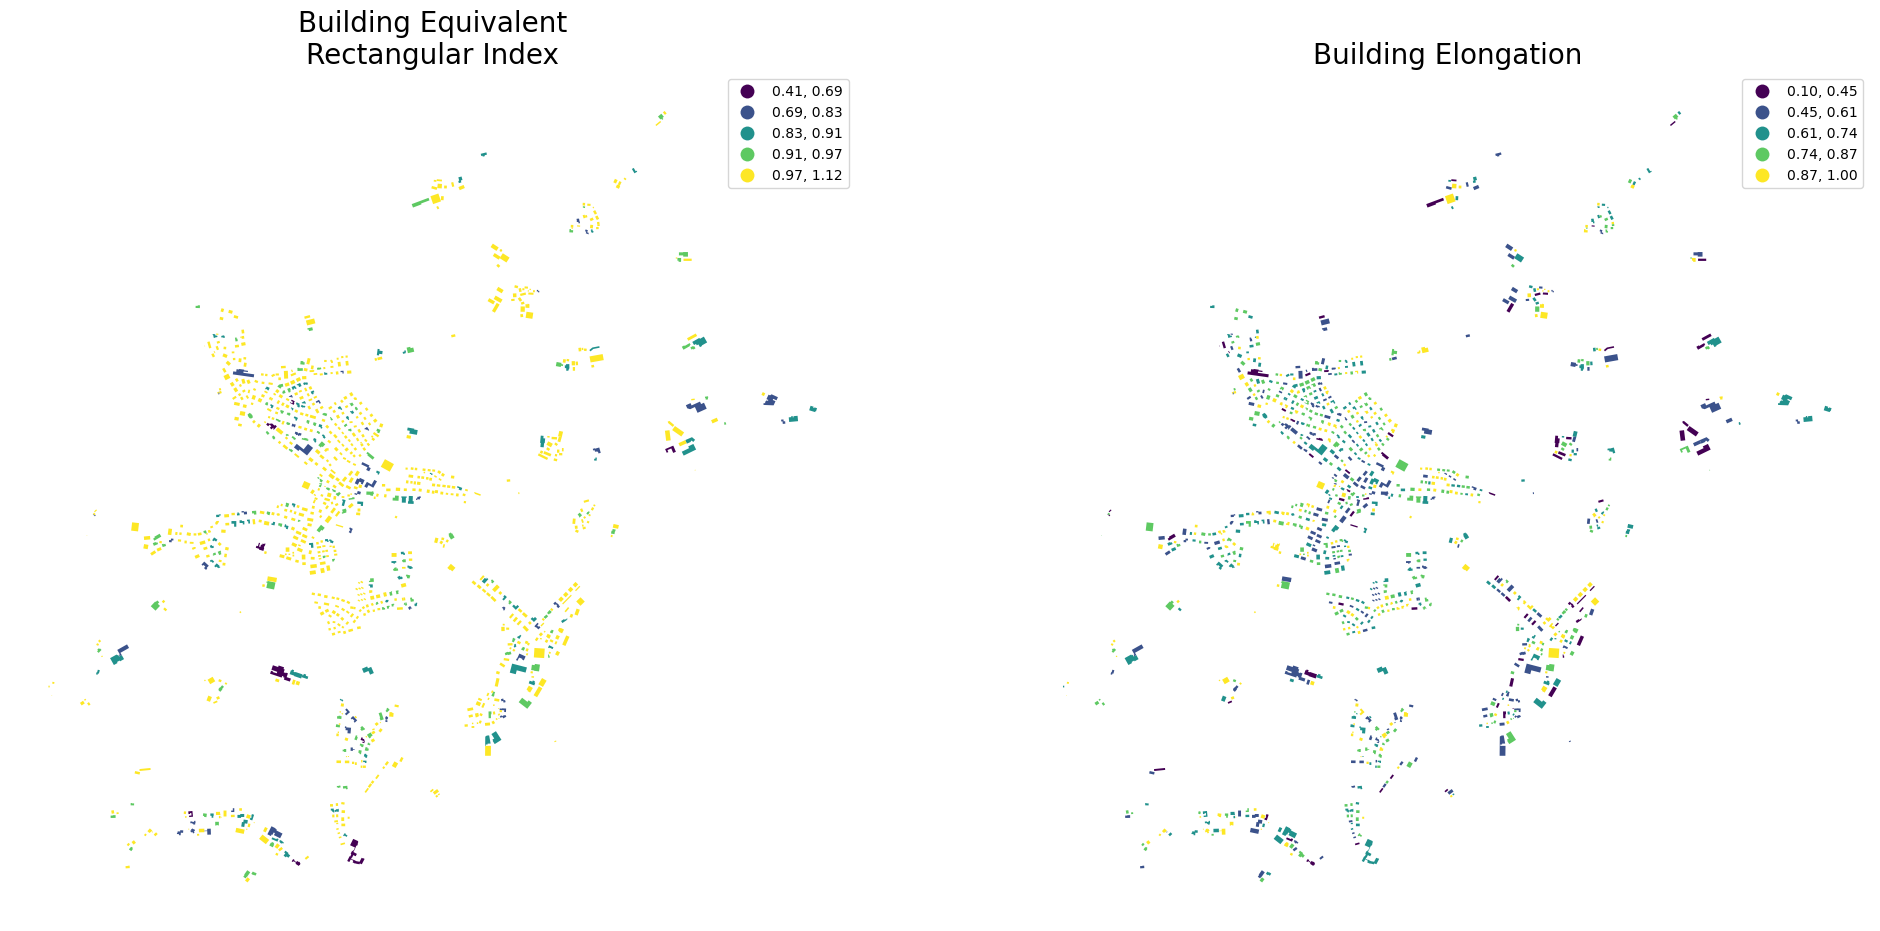

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Building Equivalent\nRectangular Index', fontsize=20)
ax[1].set_title('Building Elongation', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Mörschwil/eri_and_elongation.svg')  

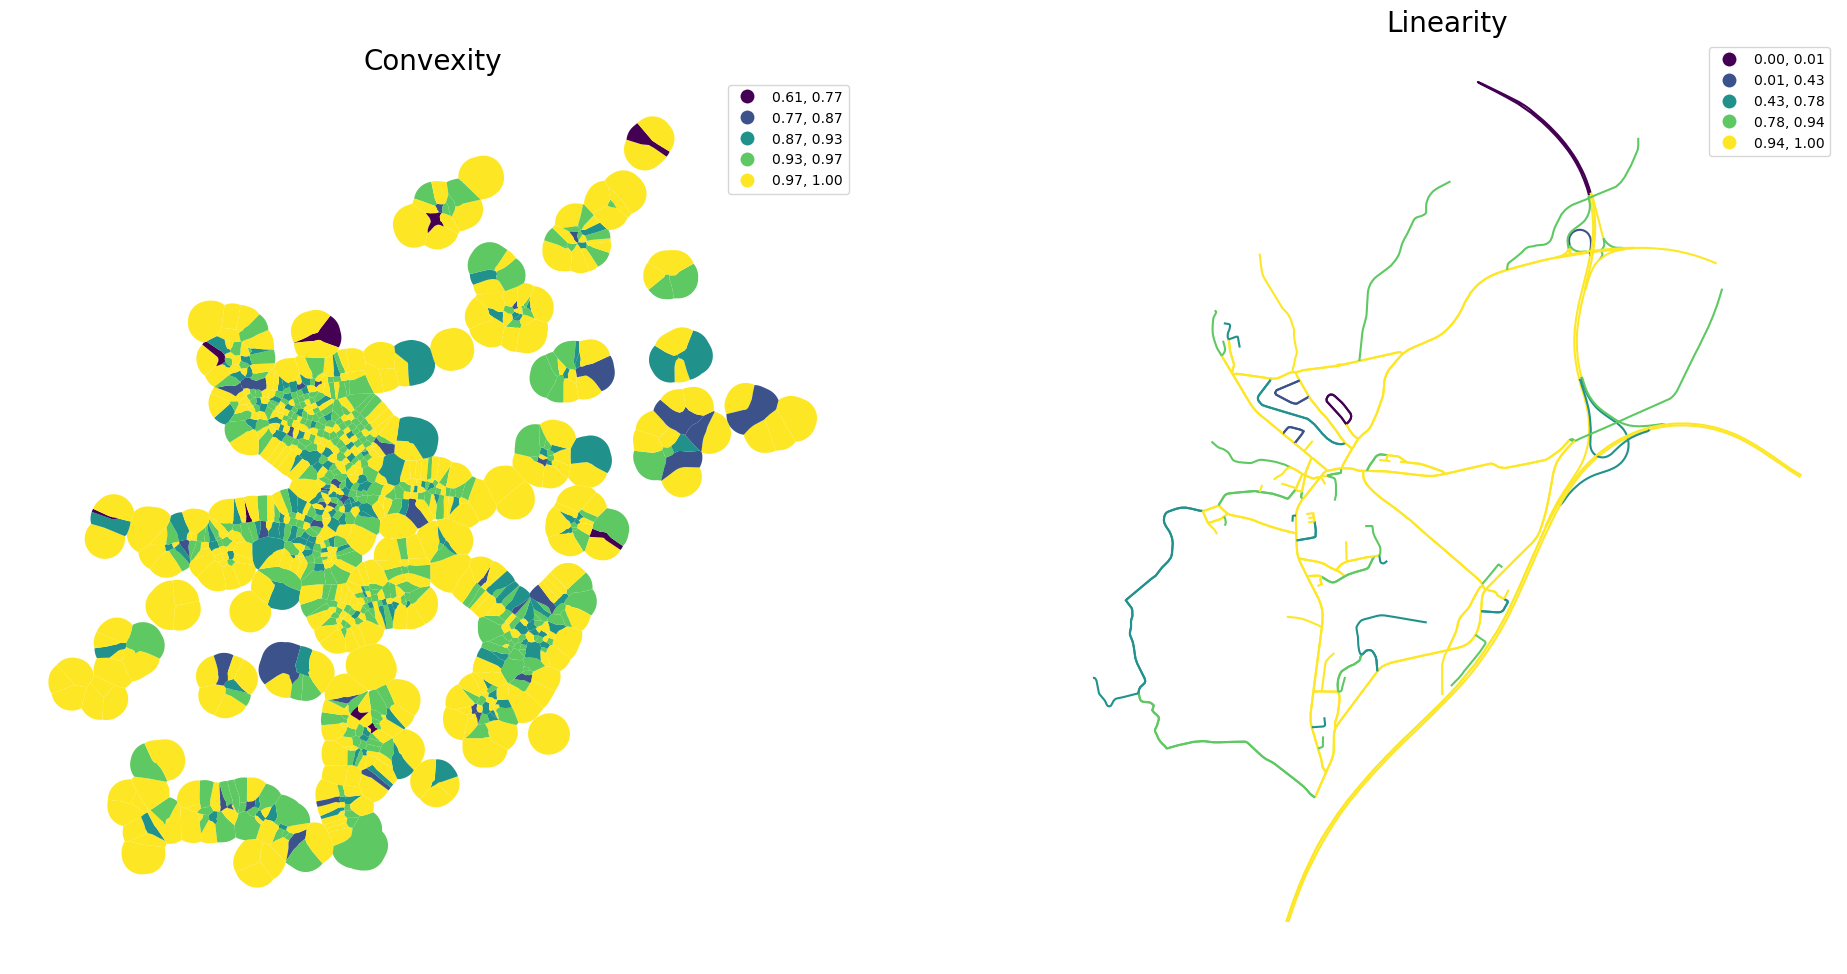

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Linearity', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Mörschwil/convexity_and_linearity.svg')  

### Spatial distribution

In [36]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/momepy/distribution.py:214: FutureWarning: Class based API like `momepy.SharedWalls` or `momepy.SharedWallsRatio` is deprecated. Replace it with `momepy.shared_walls` or explicitly computing `momepy.shared_walls / gdf.length` respectively to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  super().__init__(gdf)


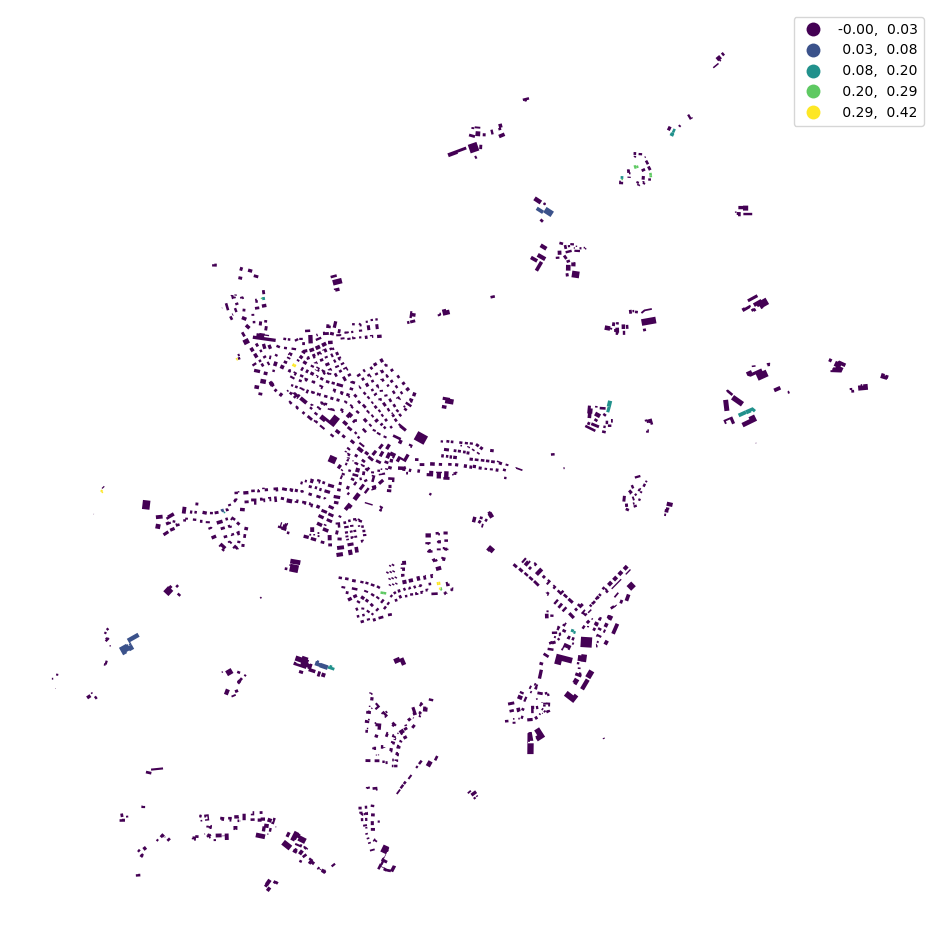

In [37]:
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

plt.savefig('../results/Mörschwil/sharedwalls.svg')  

Generate spatial weights matrix using `libpysal`.

In [38]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [39]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/1669107924.py:1: FutureWarning: Class based API like `momepy.Neighbors` is deprecated. Replace it with `momepy.neighbors` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/1669107924.py:2: FutureWarning: `momepy.CoveredArea` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series


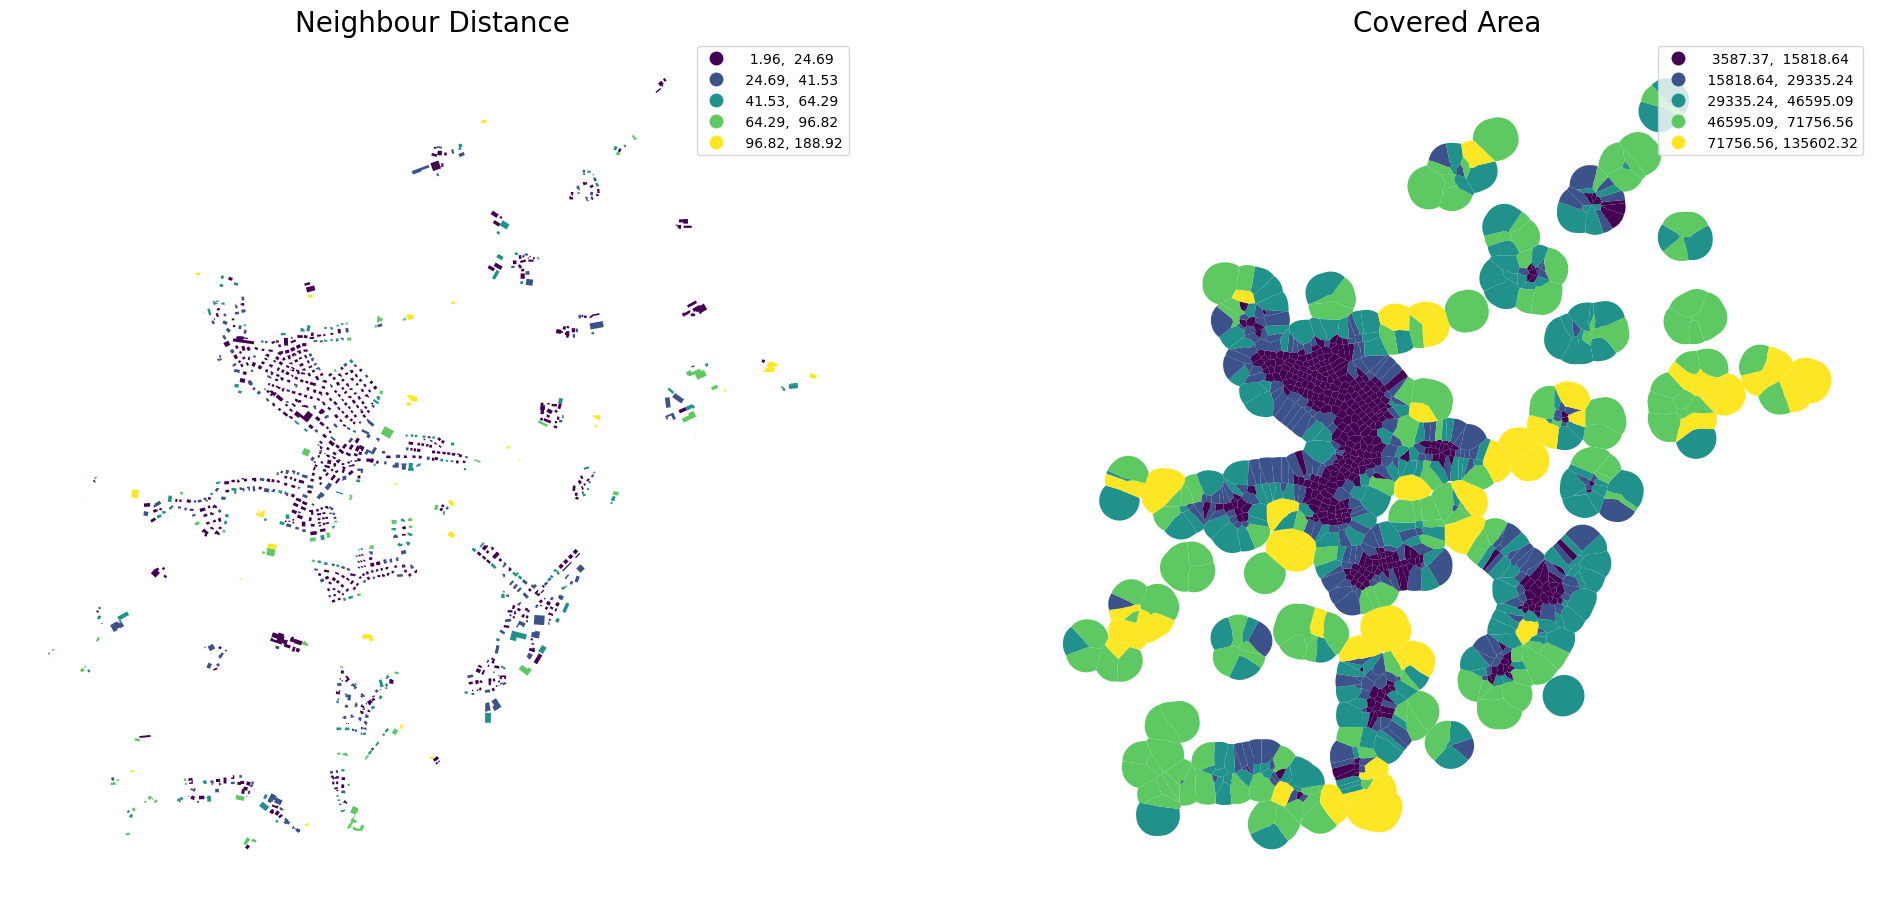

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Neighbour Distance', fontsize=20)
ax[1].set_title('Covered Area', fontsize=20)


ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Mörschwil/neighbourdist_and_coveredarea.svg')  

In [41]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/3221532125.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  queen_3 = momepy.sw_high(k=3, weights=queen_1)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/3221532125.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/3221532125.py:4: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['interbuilding_distance'] 

In [42]:
#fig, ax = plt.subplots(1, 2, figsize=(24, 12))
#
#buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
#buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)
#
#ax[0].set_axis_off()
#ax[1].set_axis_off()

In [43]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/2648127835.py:1: FutureWarning: Class based API like `momepy.StreetProfile` is deprecated. Replace it with `momepy.street_profile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  profile = momepy.StreetProfile(streets, buildings)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in intersection
  return getattr(ufunc, method)(*new_inputs, **kwargs)


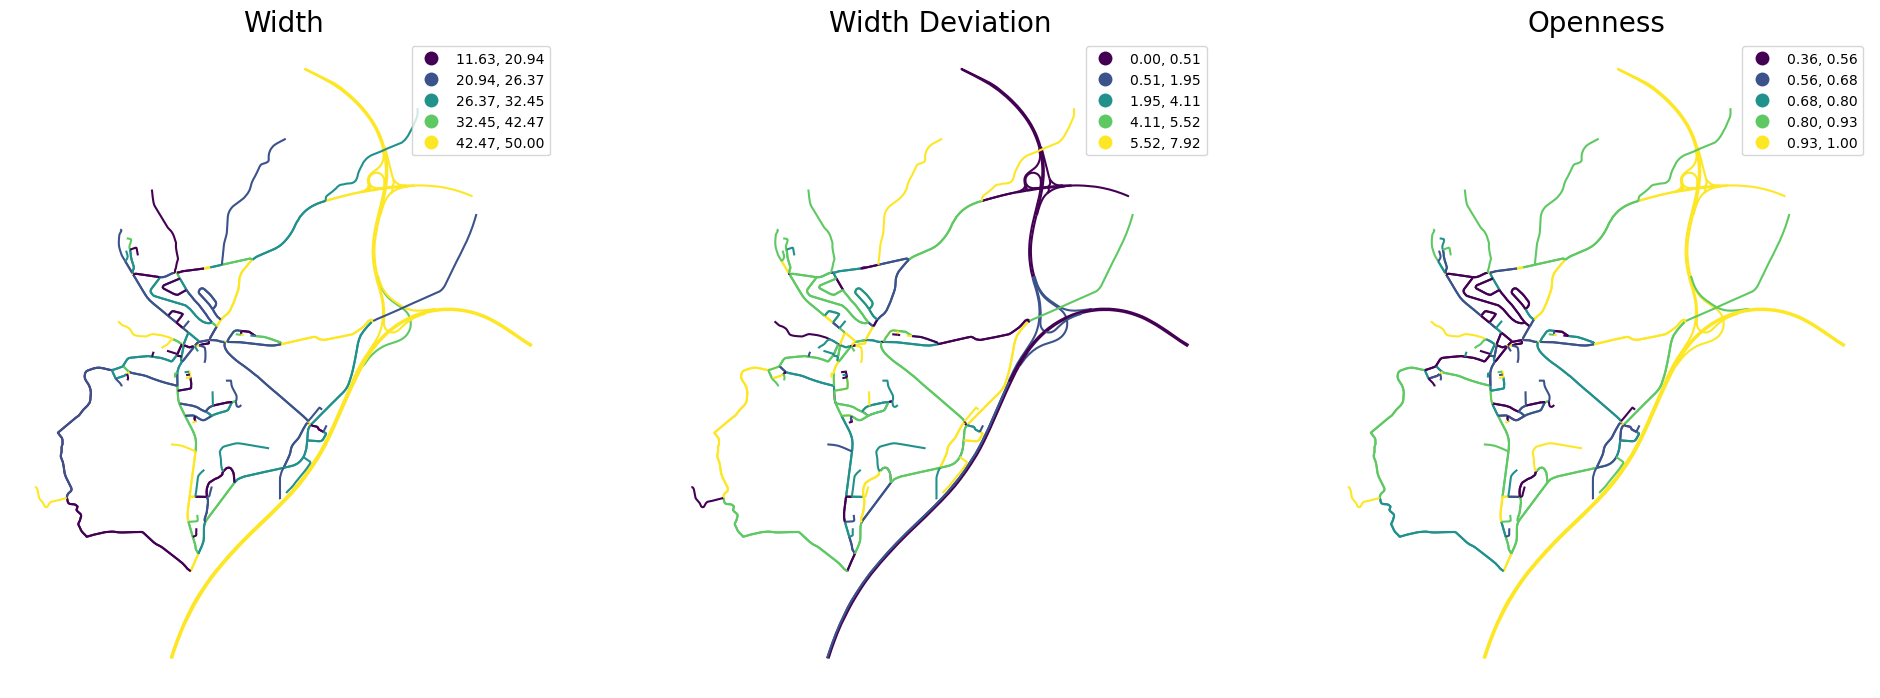

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_title('Width', fontsize=20)
ax[1].set_title('Width Deviation', fontsize=20)
ax[2].set_title('Openness', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Mörschwil/road_network.svg')  

### Intensity

In [45]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/1819725789.py:1: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series


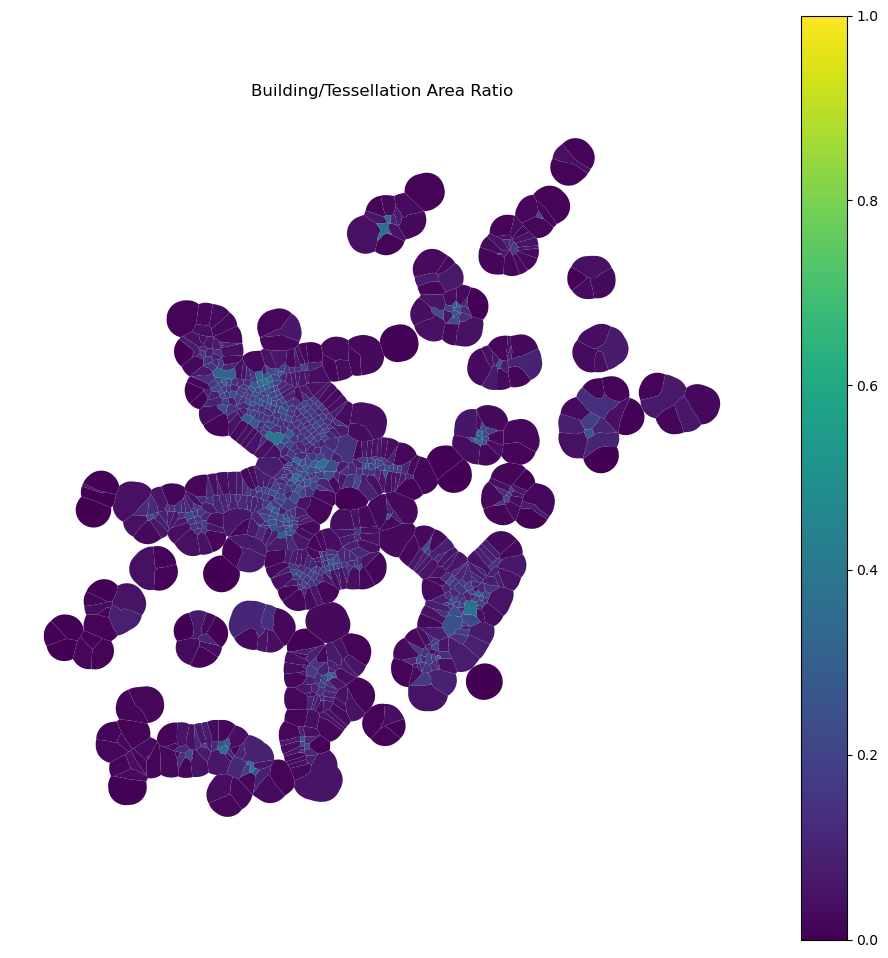

In [46]:
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()
plt.title("Building/Tessellation Area Ratio")

plt.savefig('../results/Mörschwil/tessellation_ratio.svg')  

### Connectivity

In [47]:
graph = momepy.gdf_to_nx(streets)

In [48]:
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

In [49]:
nodes, streets = momepy.nx_to_gdf(graph)

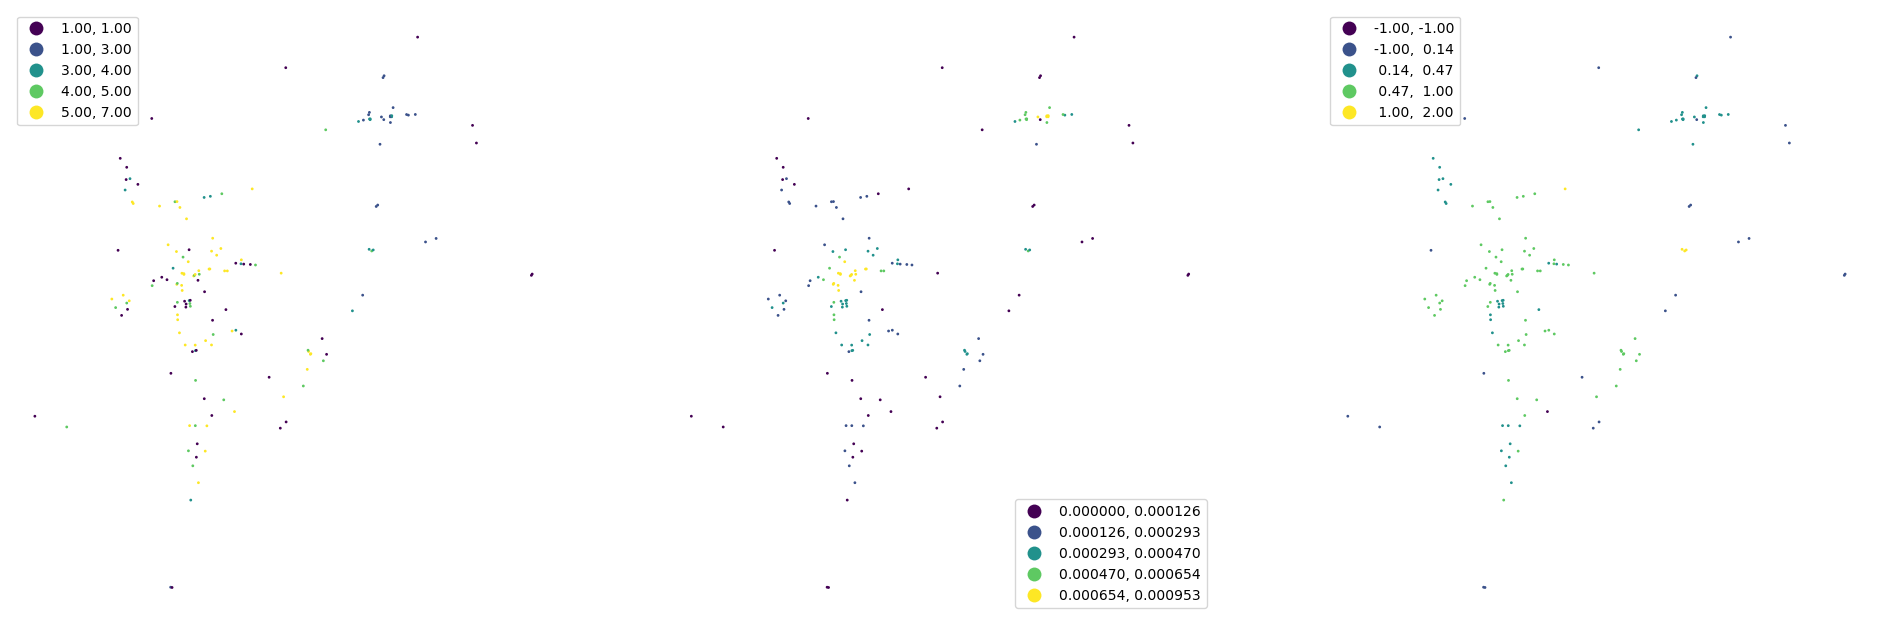

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Mörschwil/connectivity.svg')  

In [51]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/403706460.py:1: FutureWarning: Class based API like `momepy.get_node_id` is deprecated. Replace it with `momepy.get_nearest_node` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")


  0%|          | 0/1054 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [52]:
tessellation

,uID,geometry,nID,area,convexity,neighbors,covered_area,car
0,582,"POLYGON ((2749082.090 1257540.759, 2749083.848...",76,15113.066069,0.986846,0.004168,45730.929497,0.019243
1,584,"POLYGON ((2749129.012 1257555.849, 2749128.777...",76,13644.042463,0.983645,0.008441,61713.536073,0.019801
2,27,"POLYGON ((2749218.925 1257596.847, 2749218.149...",76,6727.463825,0.976888,0.020271,56462.870172,0.019030
3,25,"POLYGON ((2749258.129 1257565.087, 2749267.094...",72,5943.604717,0.868732,0.012239,53860.888281,0.093145
4,26,"POLYGON ((2749256.215 1257675.505, 2749255.404...",72,967.256187,0.951472,0.030311,18328.913735,0.241388
...,...,...,...,...,...,...,...,...
1049,496,"POLYGON ((2750927.947 1260902.474, 2750927.604...",304,27509.688136,0.968245,0.003113,47942.935446,0.009859
1050,492,"POLYGON ((2750793.450 1260819.049, 2750753.830...",304,14474.930350,0.992311,0.011070,67199.233983,0.017684
1051,499,"POLYGON ((2751031.655 1261166.187, 2751033.425...",12,21261.965661,0.985069,0.001745,32164.857140,0.009589
1052,498,"POLYGON ((2751062.425 1261161.172, 2751061.001...",12,10902.891480,0.747441,0.003483,51219.455986,0.039544


In [53]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [54]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'x', 'y', 'degree', 'closeness',
       'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [55]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42252/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API

In [56]:
percentiles_joined = pandas.concat(percentiles, axis=1)

In [57]:
percentiles_joined

,area_x_25,area_x_50,area_x_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,y_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
0,1714.878993,4107.194066,13644.042463,0.946312,0.953541,0.975530,0.012239,0.020271,0.030869,30465.383388,...,1.257512e+06,4.0,4.0,4.0,0.000066,0.000066,0.000066,0.666667,0.666667,0.666667
1,1714.878993,4107.194066,13644.042463,0.950323,0.954179,0.979120,0.013681,0.020216,0.030311,30465.383388,...,1.257512e+06,4.0,4.0,4.0,0.000066,0.000066,0.000066,0.666667,0.666667,0.666667
2,1797.753435,3958.338670,12439.791815,0.950364,0.965899,0.981382,0.012960,0.017934,0.027748,31448.751376,...,1.257512e+06,4.0,4.0,4.0,0.000066,0.000066,0.000066,0.666667,0.666667,0.666667
3,2140.446732,3809.483275,13644.042463,0.950796,0.966166,0.980775,0.012239,0.017845,0.026753,30624.328104,...,1.257654e+06,4.0,4.0,5.0,0.000066,0.000066,0.000152,0.454545,0.666667,0.666667
4,2210.040161,6335.534271,14613.466564,0.948554,0.967983,0.981382,0.010191,0.017770,0.024017,31448.751376,...,1.257512e+06,4.0,4.0,4.0,0.000066,0.000066,0.000066,0.666667,0.666667,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,3348.485867,4841.130066,13178.021276,0.946708,0.968245,0.991455,0.010591,0.012651,0.020284,27649.135082,...,1.260537e+06,5.0,5.0,5.0,0.000107,0.000107,0.000107,0.444444,0.444444,0.444444
1050,1534.656764,4222.759778,9410.150322,0.946708,0.968458,0.991213,0.011629,0.016802,0.025240,19519.751913,...,1.260537e+06,5.0,5.0,5.0,0.000107,0.000107,0.000107,0.444444,0.444444,0.444444
1051,14978.745163,19054.598846,20158.282253,0.866255,0.985069,0.991640,0.001784,0.001822,0.002653,31061.173733,...,1.260979e+06,3.0,3.0,3.0,0.000111,0.000111,0.000111,0.222222,0.222222,0.222222
1052,14978.745163,19054.598846,20158.282253,0.866255,0.985069,0.991640,0.001784,0.001822,0.002653,31061.173733,...,1.260979e+06,3.0,3.0,3.0,0.000111,0.000111,0.000111,0.222222,0.222222,0.222222


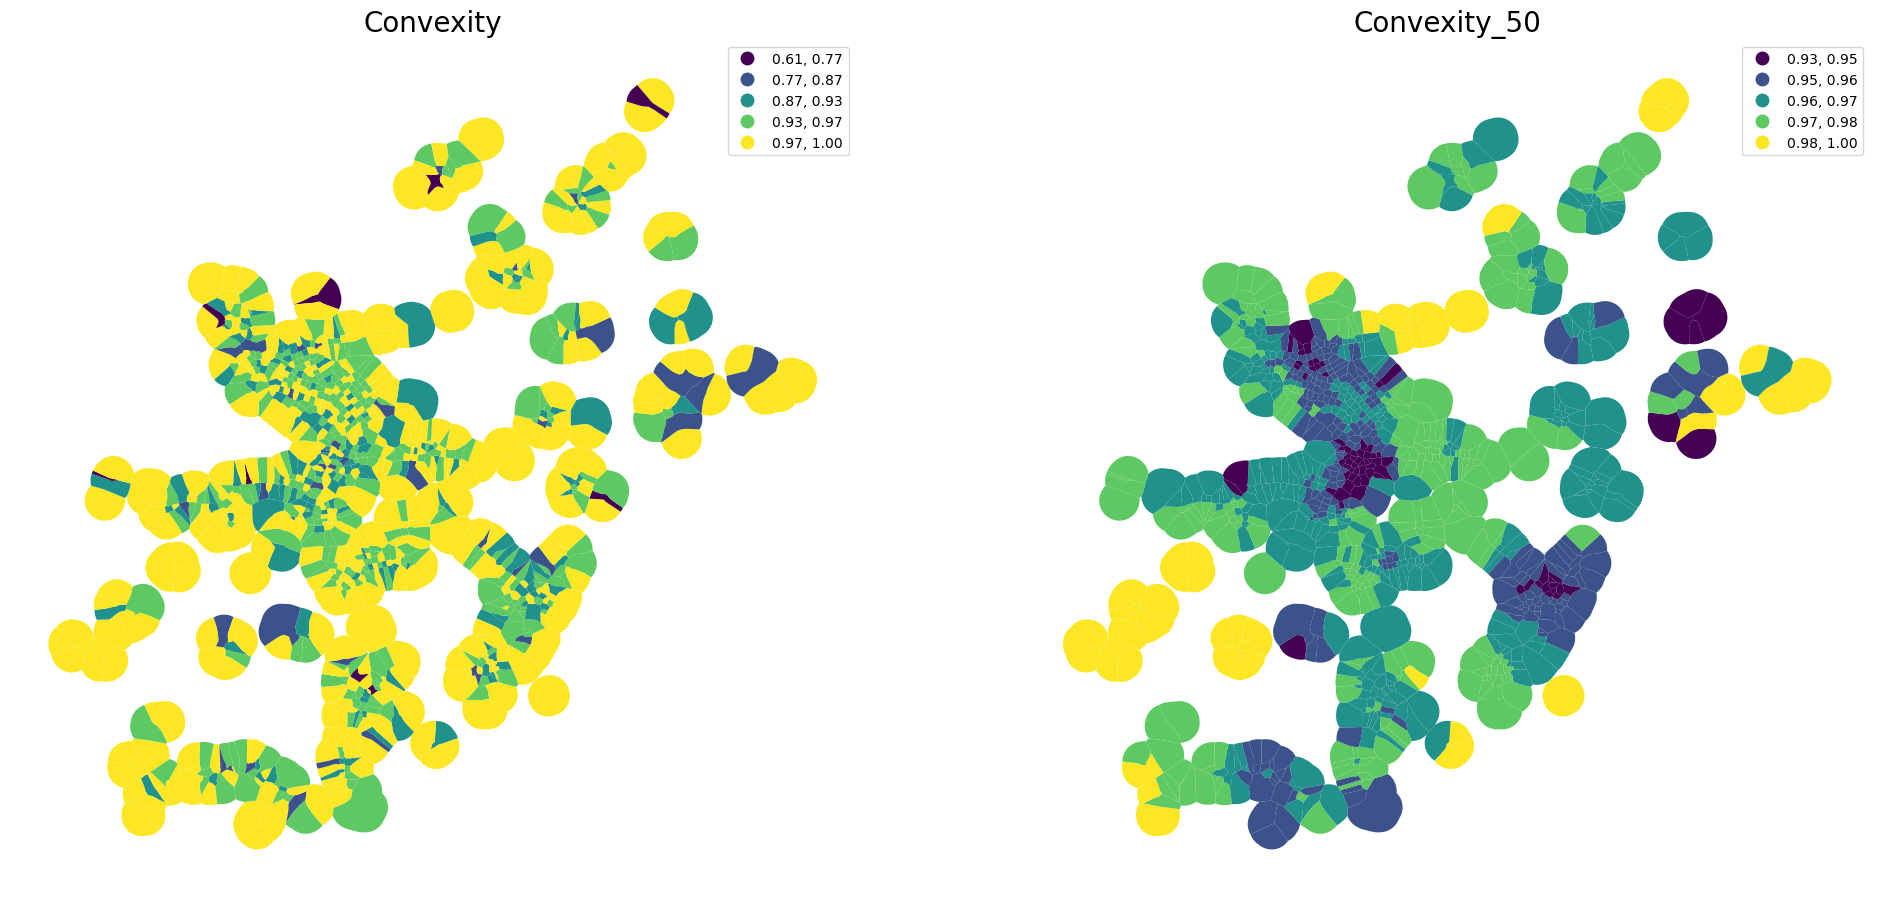

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Convexity_50', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Mörschwil/convexity.svg')  

## Clustering

Standardize values before clustering.

In [59]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

In [60]:
standardized

,area_x_25,area_x_50,area_x_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,y_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
0,-0.065730,0.238627,1.478100,0.508719,-1.196879,-0.591520,-0.797536,-0.710580,-0.597906,1.122347,...,-2.442119,-0.238284,-1.086795,-1.551876,-0.890564,-1.016205,-1.150921,0.470619,0.253022,0.008788
1,-0.065730,0.238627,1.478100,0.757000,-1.122673,-0.035705,-0.652372,-0.715369,-0.643074,1.122347,...,-2.442119,-0.238284,-1.086795,-1.551876,-0.890564,-1.016205,-1.150921,0.470619,0.253022,0.008788
2,-0.032804,0.195499,1.238924,0.759510,0.239406,0.314620,-0.724954,-0.914735,-0.850446,1.204175,...,-2.442119,-0.238284,-1.086795,-1.551876,-0.890564,-1.016205,-1.150921,0.470619,0.253022,0.008788
3,0.103349,0.152371,1.478100,0.786252,0.270455,0.220504,-0.797536,-0.922440,-0.930956,1.135573,...,-2.246686,-0.238284,-1.086795,-0.585735,-0.890564,-1.016205,-0.768921,-0.242538,0.253022,0.008788
4,0.130998,0.884242,1.670637,0.647486,0.481543,0.314620,-1.003634,-0.928986,-1.152395,1.204175,...,-2.442119,-0.238284,-1.086795,-1.551876,-0.890564,-1.016205,-1.150921,0.470619,0.253022,0.008788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,0.583306,0.451270,1.385543,0.533236,0.512023,1.874023,-0.963451,-1.376215,-1.454502,0.888001,...,1.724821,0.339740,-0.231639,-0.585735,-0.632186,-0.805307,-0.968001,-0.276498,-0.435983,-0.591610
1050,-0.137333,0.272110,0.637207,0.533236,0.536749,1.836647,-0.858908,-1.013550,-1.053437,0.211538,...,1.724821,0.339740,-0.231639,-0.585735,-0.632186,-0.805307,-0.968001,-0.276498,-0.435983,-0.591610
1051,5.204037,4.569326,2.771892,-4.447032,2.467324,1.902672,-1.850011,-2.322111,-2.881272,1.171924,...,2.333300,-0.816309,-1.941952,-2.518017,-0.612154,-0.788956,-0.953819,-1.023615,-1.124987,-1.192008
1052,5.204037,4.569326,2.771892,-4.447032,2.467324,1.902672,-1.850011,-2.322111,-2.881272,1.171924,...,2.333300,-0.816309,-1.941952,-2.518017,-0.612154,-0.788956,-0.953819,-1.023615,-1.124987,-1.192008


### How many clusters?

In [61]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.020 seconds.
K=3 fitted in 0.023 seconds.
K=4 fitted in 0.028 seconds.
K=5 fitted in 0.026 seconds.
K=6 fitted in 0.025 seconds.
K=7 fitted in 0.030 seconds.
K=8 fitted in 0.026 seconds.
K=9 fitted in 0.028 seconds.
K=10 fitted in 0.035 seconds.
K=11 fitted in 0.067 seconds.


Clustergram(k_range=range(1, 12), backend='sklearn', method='kmeans', kwargs={'n_init': 10, 'random_state': 0})

In [62]:
show(cgram.bokeh())

In [63]:
cgram.labels.head()

,1,2,3,4,5,6,7,8,9,10,11
0,0,0,2,2,1,5,1,2,2,4,4
1,0,0,2,2,1,5,1,2,2,4,4
2,0,0,2,2,1,5,1,2,2,4,4
3,0,0,2,2,1,5,1,2,2,4,4
4,0,0,2,2,1,5,1,2,2,4,4


In [64]:
merged["cluster"] = cgram.labels[8].values

In [65]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

In [66]:
urban_types.explore("cluster", categorical=True, prefer_canvas=True, tiles="CartoDB Positron", tooltip=False)

## Export

Save cluster output geodata to geojson file:

In [67]:
urban_types.to_file('../data/raw/Mörschwil.geojson', driver='GeoJSON')

## Utilities

Once you run the cell below, it hides all cells below the currently active one (aka presentation mode).

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: none;
}
</style>

Run this cell to turn the presentation mode off.

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: block;
}
</style>